# Predicting the Success of a Kickstarter Campaign
Part 1. Initial screening of an assortment of ML models.

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import matplotlib.cm as cm
# %matplotlib inline
# import seaborn as sns

from sqlalchemy import create_engine

from sklearn.naive_bayes import GaussianNB, BernoulliNB,MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.svm import SVC 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import (accuracy_score, classification_report,confusion_matrix, precision_score, 
                             recall_score, f1_score, roc_curve, roc_auc_score, average_precision_score, 
                             precision_recall_curve, auc)

from sklearn.cross_validation import train_test_split 
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler 

from xgboost import XGBClassifier

import datetime
import warnings
import os

warnings.filterwarnings("ignore")

In [2]:
# env variable at tensorflow1.4 per https://conda.io/docs/user-guide/tasks/manage-environments.html#saving-environment-variables
# and https://vsupalov.com/flask-sqlalchemy-postgres/

def get_env_variable(name):
    try:
        return os.environ[name]
    except KeyError:
        message = "Expected environment variable '{}' not set.".format(name)
        raise Exception(message)

POSTGRES_URL = get_env_variable("POSTGRES_URL")
POSTGRES_USER = get_env_variable("POSTGRES_USER")
POSTGRES_PW = get_env_variable("POSTGRES_PW")
POSTGRES_DB = get_env_variable("POSTGRES_DB")

In [3]:
DB_URL = 'postgresql+psycopg2://{user}:{pw}@{url}/{db}'.format(user=POSTGRES_USER,pw=POSTGRES_PW,url=POSTGRES_URL,db=POSTGRES_DB)

In [4]:
engine_var = DB_URL
engine = create_engine(engine_var)

In [5]:
# df = pd.read_pickle('data/kickstarter_data_ds2.pkl')
df = pd.read_sql_query('''SELECT * FROM kickstarter_data_ds2''',engine)
df['idx'] = df['id']
df = df.set_index('idx')
df = df.drop(['index'],1)
print(df.shape)
pd.read_sql_query('''SELECT state, category_main, category_name, backers_count, pct_goal_achieved, usd_pledged, usd_goal, country, currency, campaign_length, staff_pick, blurb_length, launched FROM kickstarter_data_ds2 LIMIT 5''',engine)

(163425, 19)


,state,category_main,category_name,backers_count,pct_goal_achieved,usd_pledged,usd_goal,country,currency,campaign_length,staff_pick,blurb_length,launched
0,0,games,Playing Cards,131,0.3,3387.000000,9999.000000,US,USD,38,0,16,2017-12-05
1,1,food,Small Batch,99,1.3,9858.000000,7500.000000,US,USD,30,1,5,2017-12-13
2,1,film_and_video,Horror,34,1.5,4611.000000,3000.000000,US,USD,32,0,23,2017-12-11
3,0,food,Farms,49,0.3,4741.000000,18000.000000,US,USD,38,1,9,2017-12-05
4,1,publishing,Fiction,13,1.0,427.185132,427.185132,CA,CAD,21,0,22,2017-12-22


In [6]:
start_date = datetime.datetime.strptime('2016-01-01', "%Y-%m-%d").date()

df = df[df['launched'] >= start_date] # filter from start date to current
df = df[['state','category_main','category_name','backers_count','usd_goal','country','currency','campaign_length',
        'staff_pick','blurb_length']]
df = df.dropna()

df.shape

(38401, 10)

In [7]:
df.columns

Index(['state', 'category_main', 'category_name', 'backers_count', 'usd_goal',
       'country', 'currency', 'campaign_length', 'staff_pick', 'blurb_length'],
      dtype='object')

In [8]:
df_dummies = pd.get_dummies(df[['category_main','category_name', 'country','currency']],drop_first=True)
df = df_dummies.merge(df,how='inner',left_index=True, right_index=True)
print(df.shape)
print(df.columns)
df.info()

(38401, 197)
Index(['category_main_comics', 'category_main_crafts', 'category_main_dance',
       'category_main_design', 'category_main_fashion',
       'category_main_film_and_video', 'category_main_food',
       'category_main_games', 'category_main_journalism',
       'category_main_music',
       ...
       'state', 'category_main', 'category_name', 'backers_count', 'usd_goal',
       'country', 'currency', 'campaign_length', 'staff_pick', 'blurb_length'],
      dtype='object', length=197)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 38401 entries, 1396766240 to 1094069811
Columns: 197 entries, category_main_comics to blurb_length
dtypes: float64(1), int64(5), object(4), uint8(187)
memory usage: 11.3+ MB


In [9]:
# removing all variables that cannot be known before a campaign is launched, such as # backers and $ pledged
df = df.dropna()
X = df.drop(['state','category_main','category_name', 'backers_count', 'country', 'currency'], 1)
y = df['state']

print(X.shape)

(38401, 191)


## Assumptions

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=42, stratify=y)

k_range = list(range(1, 101))
print(X_train.shape, y_train.shape)
print(X_test.shape,y_test.shape)

(26880, 191) (26880,)
(11521, 191) (11521,)


In [11]:
# https://elitedatascience.com/python-machine-learning-tutorial-scikit-learn
scaler = StandardScaler().fit(X_train)
X_train_s = scaler.transform(X_train)
X_test_s = scaler.transform(X_test)

## Phase 1: Initial Check on All Models

In [12]:
# Define models to test
model_list = [['GaussianNB', GaussianNB()], 
                ['BernoulliNB', BernoulliNB(alpha=0.5)], 
                ['MultinomialNB', MultinomialNB(alpha=0)],
                ['DecisionTree', DecisionTreeClassifier(criterion = 'gini', max_depth=2, splitter='best')], 
                ['KNN', KNeighborsClassifier(27)], # best k from KNN model below; scale data
                ['RandomForest', RandomForestClassifier(max_features='auto',n_estimators=1000)], 
                ['GradientBoost', GradientBoostingClassifier(n_estimators=500)],
                ['AdaBoost', AdaBoostClassifier(algorithm='SAMME.R',
                      base_estimator=DecisionTreeClassifier(criterion = 'gini', max_depth=2, splitter='best'),
                      n_estimators=2)],
                ['XGBoost', XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.7,
                       gamma=0, learning_rate=0.05, max_delta_step=0, max_depth=6,
                       min_child_weight=11, missing=-999, n_estimators=500, nthread=4,
                       objective='reg:linear', reg_alpha=0, reg_lambda=1,
                       scale_pos_weight=1, seed=0, silent=1, subsample=0.8)],
                ['LogisticRegression', LogisticRegression(C=1000, penalty='l1')],          
#                 ['LogisticRegressionCV', LogisticRegressionCV()]] # scale data; F1 0.62
                ['SVM', SVC(C=10,gamma=0.001,probability=True)]] # scale data; F1 0.57

model_list_s = ['KNN','LogisticRegression','SVM'] 

# Calculate metrics for each model
roc = {}
results_dict = {}
for model in model_list:
    if model[0] in model_list_s:
        X_train = X_train_s
        X_test = X_test_s
    
    model_name = model[0]
    model = model[1]
    
    accuracy = []
    precision_1 = []
    precision_0 = []
    recall_1 = []
    recall_0 = []
    f1_1 = []
    f1_0 = []
    auc = []
        
    # Perform K-Fold CV and calculate metrics for each fold
    kf = KFold(5, random_state=42, shuffle=True) 
    for train_idx, test_idx in kf.split(X, y=y):
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy.append(accuracy_score(y_test, y_pred))
        precision_1.append(precision_score(y_test, y_pred ,pos_label=1))
        precision_0.append(precision_score(y_test, y_pred ,pos_label=0))
        recall_1.append(recall_score(y_test, y_pred, pos_label=1))
        recall_0.append(recall_score(y_test, y_pred, pos_label=0))
        f1_1.append(f1_score(y_test, y_pred, pos_label=1))
        f1_0.append(f1_score(y_test, y_pred, pos_label=0))
        auc.append(roc_auc_score(y_test, y_pred))
        
    # Calculate mean metric across K-folds
    mean_accuracy = np.mean(accuracy)
    mean_precision_1 = np.mean(precision_1)
    mean_precision_0 = np.mean(precision_0)
    mean_recall_1 = np.mean(recall_1)
    mean_recall_0 = np.mean(recall_0)
    mean_f1_1 = np.mean(f1_1)
    mean_f1_0 = np.mean(f1_0)
    mean_auc = np.mean(auc)
    
    # Capture TPR and FPR from last fold for plotting
    y_score = model.predict_proba(X_test)[:,1]
    roc[model_name] = roc_curve(y_test, y_score), mean_auc
    results_dict[model_name] = {"accuracy": mean_accuracy, "precision_s": mean_precision_1, "precision_f": mean_precision_0, "recall_s": mean_recall_1, "recall_f": mean_recall_0, "f1_s": mean_f1_1, "f1_f": mean_f1_0, "auc": mean_auc}
    
    # Print formatted results
    print(model)
    print('\t==============================')
    print('\tAccuracy:', mean_accuracy)
    print('\tAUC:', mean_auc)
    print('\n')
    print(confusion_matrix(y_test,y_pred))
    print(classification_report(y_test,y_pred)) 

GaussianNB(priors=None)
	Accuracy: 0.578856002083
	AUC: 0.535151254992


[[ 443 4758]
 [  94 6226]]
             precision    recall  f1-score   support

          0       0.82      0.09      0.15      5201
          1       0.57      0.99      0.72      6320

avg / total       0.68      0.58      0.46     11521

BernoulliNB(alpha=0.5, binarize=0.0, class_prior=None, fit_prior=True)
	Accuracy: 0.727541012065
	AUC: 0.729856934767


[[3920 1281]
 [1858 4462]]
             precision    recall  f1-score   support

          0       0.68      0.75      0.71      5201
          1       0.78      0.71      0.74      6320

avg / total       0.73      0.73      0.73     11521

MultinomialNB(alpha=0, class_prior=None, fit_prior=True)
	Accuracy: 0.613835604548
	AUC: 0.582132178817


[[1330 3871]
 [ 578 5742]]
             precision    recall  f1-score   support

          0       0.70      0.26      0.37      5201
          1       0.60      0.91      0.72      6320

avg / total       0.64      0

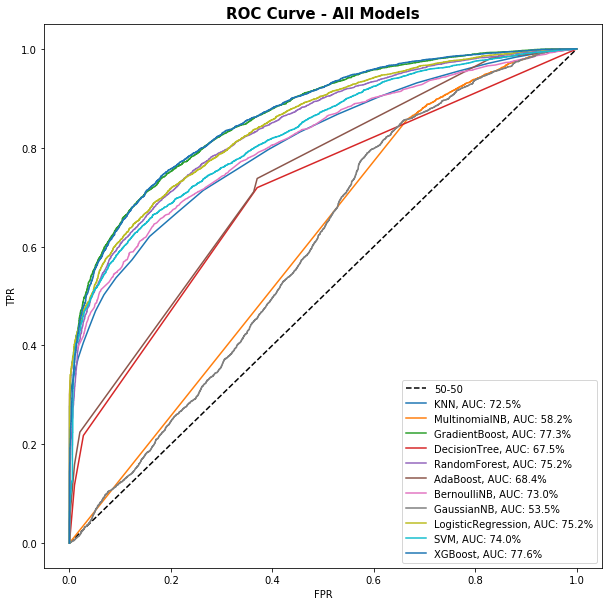

In [15]:
# Plot the ROC curve from the last K-Fold split
fig, ax = plt.subplots(figsize=(10, 10))

# Plot 50-50 Line
ax.plot([0,1],[0,1], ls='--', color='k', label='50-50')

# Plot Classifier ROC Curves
for key, value in roc.items():
    label = '{}, AUC: {}%'.format(key, round(100*value[1],1))
    ax.plot(roc[key][0][0], roc[key][0][1], label=label)
    
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
ax.set_title('ROC Curve - All Models',fontweight='bold',fontsize=15)
ax.legend(loc='best')
plt.savefig('../charts/roc_ds2_p1.png')

In [16]:
rd = pd.DataFrame(results_dict).T
rd = rd.apply(lambda x: round(100*x,1).astype(str) + "%")
rd = rd.sort_values(['auc'],ascending=[False])
rd

,accuracy,auc,f1_f,f1_s,precision_f,precision_s,recall_f,recall_s
XGBoost,77.6%,77.6%,75.9%,79.0%,73.7%,81.1%,78.2%,77.1%
GradientBoost,77.2%,77.3%,75.5%,78.8%,73.5%,80.7%,77.6%,77.0%
LogisticRegression,75.2%,75.2%,73.3%,76.8%,71.3%,78.8%,75.5%,74.9%
RandomForest,75.4%,75.2%,72.9%,77.4%,72.4%,77.8%,73.3%,77.0%
SVM,73.7%,74.0%,72.7%,74.6%,68.4%,79.2%,77.6%,70.5%
BernoulliNB,72.8%,73.0%,71.4%,74.0%,67.8%,77.7%,75.4%,70.6%
KNN,72.4%,72.5%,70.7%,73.9%,67.9%,76.7%,73.6%,71.4%
AdaBoost,68.9%,68.4%,64.7%,72.2%,66.4%,70.8%,63.0%,73.8%
DecisionTree,67.9%,67.5%,63.9%,71.1%,64.9%,70.3%,63.0%,71.9%
MultinomialNB,61.4%,58.2%,37.4%,72.1%,69.7%,59.7%,25.6%,90.9%
